# 네이버 영화리뷰 감성 분석



In [166]:
from collections import Counter
import os
import re
import urllib.request

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from konlpy.tag import Mecab
from konlpy.tag import Okt

from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
%matplotlib inline

<hr>

## Data Description

- [네이버 영화 댓글 데이터셋](https://github.com/e9t/nsmc)

- 200K reviews in total
    - train.txt: 150K reviews
    - test.txt: 50K reviews
- label
    - each class is sampled equally
    - 0: negative \(100K reviews of ratings 1-4\)
    - 1: positive \(100K reviews of ratings 9-10\)
    - neutral reviews\(ratings 5-8\) are excluded
    
- All reveiws are shorter than 140 characters

<hr>

In [37]:
train_data = pd.read_table('~/aiffel/aiffel_projects/exploration/E7_sentimental_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_projects/exploration/E7_sentimental_classification/data/ratings_test.txt')

In [4]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<br>

## 데이터 전처리 과정

- 1) 중복 데이터 제거
- 2) 결측치 제거
- 3) 토큰화
- 4) 불용어 제거
- 5) word_to_index, index_to_word 딕셔너리 생성
- 6) train, test dataset 최종 생성

In [38]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print("train data:", train_data.shape)
print("test data", test_data.shape)

train data: (146183, 3)
test data (49158, 3)


In [39]:
# 결측치 제거
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)

print("train data:", train_data.shape)
print("test data", test_data.shape)

train data: (146182, 3)
test data (49157, 3)


### - 토큰화

- tokenize는 Mecab과 Okt를 비교한 결과 Okt를 이용하기로 결정
    - Okt가 띄어쓰기 오류나 오타에 대해 더 정확하게 처리하고, 정규화 등의 기능을 제공함
    - 단점은 Mecab에 비해 시간이 매....우 오래 걸렸다 ㅠㅠㅠ 약 1시간 소요됨
- 더 자세한 비교는 [이 글](https://soohee410.github.io/compare_tagger)을 참고

In [30]:
# 토큰화 및 불용어와 문장 부호 제거
tokenizer = Okt()

# 불용어 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in train_data['document']:
    # 토큰화
    temp_X = tokenizer.morphs(sentence, stem=True)
    
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords]
    
    # 특수 기호 제거
    punc = re.compile('[.?,!>)(:~\-@/%]')
    temp_X = [punc.sub('', word) for word in temp_X]
    
    # 빈 word 제거
    temp_X = [word for word in temp_X if word != '']
    
    X_train.append(temp_X)

In [32]:
# test dataset에 대해 반복
X_test = []
for sentence in test_data['document']:
    # 토큰화
    temp_X = tokenizer.morphs(sentence, stem=True)
    
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords]
    
    # 특수 기호 제거
    punc = re.compile('[.?,!>)(:~\-@/%]')
    temp_X = [punc.sub('', word) for word in temp_X]
    
    # 빈 word 제거
    temp_X = [word for word in temp_X if word != '']
    
    X_test.append(temp_X)

In [35]:
# 처리 결과 살펴보기
X_train[:4]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [36]:
X_test[:4]

[['굳다', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

In [115]:
# 토큰화를 다시 할 수는 없다.. 복사해서 다른 변수로 쓰자
final_X_train = X_train[:]
final_X_test = X_test[:]

In [116]:
print("train data:", len(final_X_train))
print("test data:", len(final_X_test))

train data: 146182
test data: 49157


### - word dictionary 생성

In [117]:
# Tokenizer.fit_on_texts() 이용
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_X_train)

In [118]:
print(len(tokenizer.word_index))

47805


In [119]:
# 너무 많으니까 빈도가 3 미만인 것들은 사용하지 않는다
cnt = 0
for key, value in tokenizer.word_counts.items():
    if value < 3:
        cnt += 1
        
print("빈도가 3 미만인 단어의 개수:", cnt)

빈도가 3 미만인 단어의 개수: 27493


In [120]:
VOCAB_SIZE = len(tokenizer.word_index) - cnt

print("train에 사용할 단어 개수:", VOCAB_SIZE)

train에 사용할 단어 개수: 20312


In [121]:
# tokenize again
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(final_X_train)

In [122]:
# text to sequence
final_X_train = tokenizer.texts_to_sequences(final_X_train)
final_X_test = tokenizer.texts_to_sequences(final_X_test)

In [123]:
# maxlen에 따라 전체 모델 성능에 영향을 미치므로
# dataset의 리뷰 길이의 분포 살펴보기
total_text = list(final_X_train) + list(final_X_test)

num_tokens = [len(tokens) for tokens in total_text]
num_tokens = np.array(num_tokens)

print("max len:", np.max(num_tokens))
print("mean len:", np.mean(num_tokens))
print("std:", np.std(num_tokens))

max len: 74
mean len: 11.044619865976584
std: 9.10804458392401


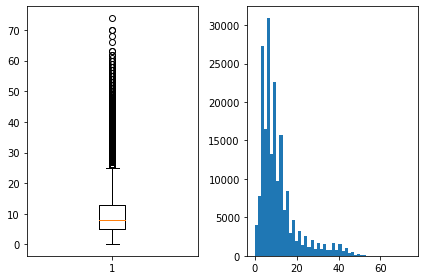

In [124]:
plt.subplot(1, 2, 1)
plt.boxplot(num_tokens)

plt.subplot(1, 2, 2)
plt.hist(num_tokens, bins=50)
plt.tight_layout()

plt.show()

In [125]:
# maxlen을 (평균 + 2*표준편차)로 설정
# 대부분의 문장이 maxlen 이내에 포함됨
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)

print('maxlen:', max_len)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens) * 100}%가 maxlen 이내에 포함됨')

maxlen: 29
전체 문장의 93.5962608593266%가 maxlen 이내에 포함됨


### - padding 추가

In [126]:
final_X_train = pad_sequences(final_X_train, padding='pre', maxlen=max_len)
final_X_test = pad_sequences(final_X_test, padding='pre', maxlen=max_len)

print(final_X_train.shape)
print(final_X_test.shape)

(146182, 29)
(49157, 29)


## 모델 설계 및 학습


In [153]:
WORD_VECTOR_DIM = 120  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

my_model = Sequential()
my_model.add(Embedding(VOCAB_SIZE, WORD_VECTOR_DIM))
my_model.add(LSTM(60))
# model.add(Dense(128, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))

my_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 120)         2437440   
_________________________________________________________________
lstm_12 (LSTM)               (None, 60)                43440     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 61        
Total params: 2,480,941
Trainable params: 2,480,941
Non-trainable params: 0
_________________________________________________________________


In [147]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [154]:
my_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history = my_model.fit(final_X_train,
                       y_train,
                       epochs=20,
                       callbacks=[es, mc],
                       batch_size=60,
                       validation_split=0.2,
                       verbose=1)

Epoch 1/20
1950/1950 [==============================] - 39s 18ms/step - loss: 0.4334 - accuracy: 0.7938 - val_loss: 0.3484 - val_accuracy: 0.8488
Epoch 2/20
1950/1950 [==============================] - 34s 18ms/step - loss: 0.2877 - accuracy: 0.8776 - val_loss: 0.3330 - val_accuracy: 0.8555
Epoch 3/20
1950/1950 [==============================] - 34s 18ms/step - loss: 0.2282 - accuracy: 0.9056 - val_loss: 0.3462 - val_accuracy: 0.8568
Epoch 4/20
1950/1950 [==============================] - 34s 18ms/step - loss: 0.1801 - accuracy: 0.9282 - val_loss: 0.3918 - val_accuracy: 0.8519
Epoch 00004: early stopping


In [156]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

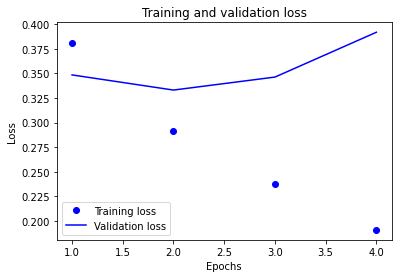

In [157]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

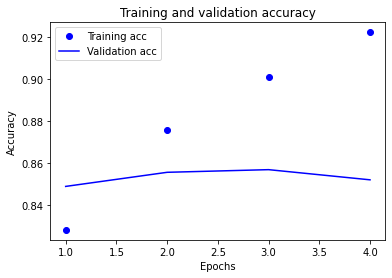

In [158]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [155]:
# 테스트셋을 통한 모델 평가
results = my_model.evaluate(final_X_test, y_test, verbose=2)

1537/1537 - 6s - loss: 0.4028 - accuracy: 0.8500


In [ ]:
# 실제 리뷰를 분류하는 함수
def sentiment_predict(new_sentence):
    # tokenize
    new_sentence = okt.morphs(new_sentence, stem=True)
    
    # stopwords 제거
    new_sentence = [word for word in new_sentence if not word in stopwords]
    
    # embedding
    embedding = tokenizer.texts_to_sequences([new_sentence])
    
    # padding
    padded = pad_sequences(embedding, maxlen=max_len)
    
    # prediction
    score = float(my_model.predict(padded))
    
    if score > 0.5:
        print(f"{score * 100:.2f}% 확률로 positive")
    else:
        print(f"{(1 - score)*100:.2f}% 확률로 negative")

In [ ]:
sentiment_predict('2시간 내내 몰입할 수 있었던 영화')

## gensim.models.Word2Vec 이용하기

- gensim 버전 주의; pip install --upgrade gensim==3.8.3

In [ ]:
word2vec_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E7_sentimental_classification/data/ko.bin'

# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
model = Word2Vec(sentences=final_X_train, workers=4, sg=0)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py", line 1155, in _worker_loop
    class BrownCorpus(object):
  File "/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py", line 946, in _do_train_job
    ----------
  File "gensim/models/word2vec_inner.pyx", line 638, in gensim.models.word2vec_inner.train_batch_cbow
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File

In [ ]:
model.wv.vectors.shape

## 평가 및 회고

- 직접 word embedding을 하고 RNN layer를 설계한 모델로 학습시킨 결과와 gensim word2vec model로 학습시킨 결과를 비교해 보았다.
- 시간을 많이 들이지 못해 이해도와 완성도가 떨어지는 것이 아쉽다.